In [1]:
import os
import h5py
import tensorflow as tf
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
from tensorflow.keras import layers
from time import strftime
from scipy.signal import spectrogram, stft, istft

In [2]:
MODEL_NAME = "GanPlayground"
EPOCHS = 25
BUFFER_SIZE = 1000
BATCH_SIZE = 16
NUM_EXAMPLES_TO_GENERATE = 1
LATENT_DIM = 100
STEAD_PATH_DB_PROCESSED_STFT_64 = "/home/jarek/github/saigon/data/STEAD-processed-stft-64.hdf5"

In [3]:
def plot_single_stream(do, label, fs=66, nperseg=127, file_path=None):
    d0 = pd.DataFrame(data=do)

    fig = plt.figure(figsize=(16, 16), dpi=60)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0))
    ax3 = plt.subplot2grid((4, 1), (2, 0), rowspan=2)

    plt.subplots_adjust(hspace=0.5)

    sns.lineplot(data=do, ax=ax1, linewidth=1, legend=None)

    ax1.set_title("Waveform")
    ax1.set(xlabel="Samples", ylabel="Amplitude counts")
    ax1.locator_params(nbins=6, axis="y")

    f, t, Sxx = spectrogram(x=do, fs=fs)

    ax2.clear()
    ax2.set_title("Spectrogram")
    ax2.pcolormesh(t, f, Sxx, shading="gouraud")
    ax2.set(xlabel="Time [sec]", ylabel="Frequency [Hz]")

    f_sftt, t_sftt, Zxx = stft(do, window="hanning", fs=fs, nperseg=nperseg)

    ax3.clear()
    ax3.set_title("STFT")
    ax3.pcolormesh(t_sftt, f_sftt, np.abs(Zxx), shading="auto")

    plt.suptitle(label, fontsize=14)

    if file_path != None:
        plt.savefig(file_path)
    else:
        plt.show()

In [4]:
def plot_stft(stream, fs=100, nperseg=155):
    f, t, Zxx = stft(stream, window='hanning', fs=fs, nperseg=nperseg)
    # plt.specgram(x_1[0][0], cmap='plasma', Fs=100)
    plt.pcolormesh(t, f, np.abs(Zxx), shading='auto')

In [5]:
def get_stft_data(file_path, arr_length):
    with h5py.File(file_path, "r") as f:
        keys = f["keys"][:arr_length]
        components = f["components"][:arr_length]
        data = f["data"][:arr_length]
        return (keys, components, data)

# Read processed data

In [6]:
(keys, components, x_train) = get_stft_data(
    STEAD_PATH_DB_PROCESSED_STFT_64, 10000
)

# Convert streams to STFT

In [7]:
# STFT of the stream and then reverse STFT back into original stream
# f, t, Zxx = stft(x_1[1][0], window='hanning', fs=100, nperseg=155)
# k2 = istft(Zxx, window='hanning', fs=100, nperseg=155)

# Reshape data

In [8]:
x_train = x_train.reshape(x_train.shape[0], 64, 64, 1)

In [9]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

2021-11-09 19:50:25.207750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 19:50:25.216817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 19:50:25.217610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 19:50:25.218894: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
train_dataset

<BatchDataset shapes: (None, 64, 64, 1), types: tf.float32>

# Logs and Tensorboard

In [11]:
folder_name = f"{MODEL_NAME} at {strftime('%H:%M')}"
log_dir = os.path.join("../log/", folder_name)

try:
    os.makedirs(log_dir)
except OSError as exception:
    print(exception.strerror)
else:
    print("Successfully created dirs!")

Successfully created dirs!


# Define GAN

In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(
        layers.Dense(2 * 2 * 128, use_bias=False, input_shape=(LATENT_DIM,))
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((2, 2, 128)))

    model.add(
        layers.Conv2DTranspose(
            64, (20, 20), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(
            64, (20, 20), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(
            64, (20, 20), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(
            64, (20, 20), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(
            64, (20, 20), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(
            1,
            (1, 1),
            strides=(1, 1),
            padding="same",
            use_bias=False,
            activation="tanh",
        )
    )

    return model

In [18]:
generator = make_generator_model()

# noise = tf.random.normal(dtype=tf.dtypes.float32, shape=[78, 78], stddev=5)
noise = tf.random.normal([BATCH_SIZE, LATENT_DIM], stddev=10e5)
generated_stft = generator(noise, training=False)

generated_stft.shape

TensorShape([16, 64, 64, 1])

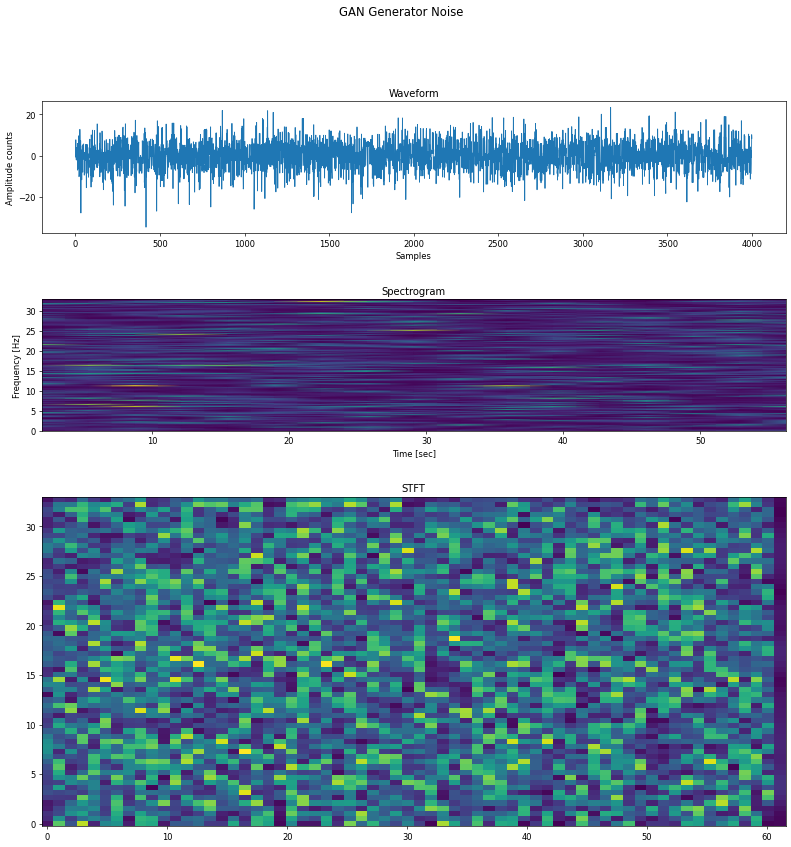

In [19]:
inversed = istft(generated_stft[0, :, :, 0], window='hanning', fs=66, nperseg=127)
plot_single_stream(inversed[1][:4000], "GAN Generator Noise")

In [24]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[64, 64, 1])
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [25]:
discriminator = make_discriminator_model()
decision = discriminator(generated_stft)
decision

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[ 0.03460738],
       [-0.10582747],
       [-0.05624683],
       [-0.02064585],
       [ 0.02504497],
       [-0.02498362],
       [-0.00833517],
       [-0.28073603],
       [ 0.05884279],
       [-0.04425319],
       [-0.1493132 ],
       [-0.06823143],
       [-0.09157231],
       [-0.10699601],
       [ 0.00110761],
       [-0.03683913]], dtype=float32)>

In [26]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, LATENT_DIM])

In [32]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [34]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        inversed = istft(
            predictions[i, :, :, 0][:4000], window="hanning", fs=66, nperseg=127
        )
        plot_single_stream(
            inversed[1][:4000],
            f"GAN Event (epoch {epoch})",
            # file_path=f"out/image_at_epoch_{epoch}.jpg"
        )

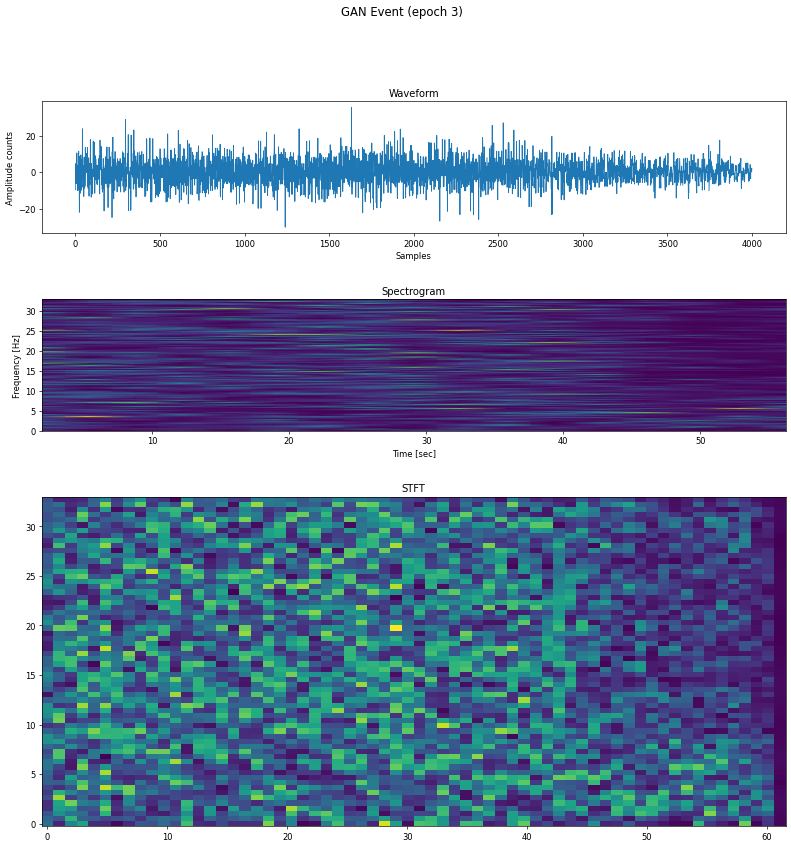

Time for epoch 3 is 45.593989849090576 sec


KeyboardInterrupt: 

In [35]:
train(train_dataset, EPOCHS)